# Visualization of Oblique Tree versus Decision Tree
This notebook follows initial visualization method from `Comparisons of Axis-Aligned and Oblique Random Forests` notebook successfully conducting visual comparison of decision surface between oblique tree and decision tree. The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using `3` more datasets: `sparse_parity`, `orthant`, `trunk`

## Environment
- Python 3.8.10
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquetrees)

## Import packages

In [1]:
from sklearn.tree import DecisionTreeClassifier, ObliqueDecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
import itertools

from datetime import datetime
import os

import numpy as np
import matplotlib.pyplot as plt

random_seed = 123456

In [2]:
today = str(datetime.now().date())
today

'2022-01-24'

#### Functions to create the datasets

In [3]:
def sparse_parity(n, p=20, p_star=3, random_seed=None):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n, p))
    y = np.zeros(n)

    for i in range(0, n):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

def orthant(n, p=6, rec=1, random_seed=None):

    if random_seed: 
        np.random.seed(random_seed)

    if rec == 10:
        print("sample size too small")
        sys.exit(0)

    orth_labels = np.asarray([2 ** i for i in range(0, p)][::-1])

    X = np.random.uniform(-1, 1, (n, p))
    y = np.zeros(n)

    for i in range(0, n):
        idx = np.where(X[i, :] > 0)[0]
        y[i] = sum(orth_labels[idx])

    # Careful not to stack overflow! 
    if len(np.unique(y)) < 2 ** p:
        X, y = orthant(n, p, rec+1)

    return X, y

def trunk(n, p=10, random_seed=None):

    if random_seed: 
        np.random.seed(random_seed)

    mu_1 = np.array([1/i for i in range(1,p+1)])
    mu_0 = -1 * mu_1

    cov = np.identity(p)

    X = np.vstack((
        np.random.multivariate_normal(mu_0, cov, int(n/2)),
        np.random.multivariate_normal(mu_1, cov, int(n/2))
        ))

    y = np.concatenate((
        np.zeros(int(n/2)),
        np.ones(int(n/2))
        ))

    return X, y

In [4]:
def cv_scores(X, y, random_seed=123456):
    clf = DecisionTreeClassifier(random_state=random_seed)
    cv_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    print(f'10-Fold CV score for axis-aligned decision tree is: {np.mean(cv_scores)} +/- {np.std(cv_scores)}')

    clf = ObliqueDecisionTreeClassifier(max_features=X.shape[1], random_state=random_seed)
    cv_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    print(f'10-Fold CV score for oblique decision tree is: {np.mean(cv_scores)} +/- {np.std(cv_scores)}')

### Functions to train trees on paired features and visualization of the trees and their decision boundaries

In [5]:
def plot_trained_tree(X, y, l, clf_names):
    for i in range(2):
        plt.figure(figsize=(l*10,l*10))
        if i == 0:
            clf = DecisionTreeClassifier().fit(X, y)
        else:
            clf = ObliqueDecisionTreeClassifier().fit(X, y)
            
        plot_tree(clf, filled=True, fontsize=10)
        plt.title(f'Visualization of an {clf_names[i]}')
        plt.show()

In [6]:
def plot_decision_boundary(X_dat, y_dat, random_state=random_seed, tree_vis=True):

    pairs = []
    n_classes = 2
    classes = ['Class 0', 'Class 1']
    clf_names = ['axis-aligned Decision Tree', 'Oblique Tree']
    plot_colors = 'rb'
    plot_step = 0.02
    n = X_dat.shape[1] #number of features

    for pair in itertools.combinations(range(n),2):
        pairs.append(pair)

    w = int(np.ceil(len(pairs)**(1/2))) #width of figure
    h = int(np.ceil(len(pairs) / w)) #height of figure

    # print(len(pairs))
    
    for clf_switch in [0,1]:
        f = plt.figure(figsize=(3*w,3*h))

        for pairidx, pair in enumerate(pairs):
            # We only take the two corresponding features
            X = X_dat[:, pair]
            y = y_dat

            # Train
            if clf_switch == 0:
                clf = DecisionTreeClassifier(random_state=random_state)
            else:
                clf = ObliqueDecisionTreeClassifier(random_state=random_state)

            clf.fit(X, y)

            # Plot the decision boundary
            ax = f.add_subplot(h,w,pairidx + 1)
            
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(
                np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
            )

            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap='RdBu')

            plt.xlabel(f'feature number {pair[0]}')
            plt.ylabel(f'feature number {pair[1]}')

            # Plot the training points
            for i, color in zip(range(n_classes), plot_colors):
                idx = np.where(y == i)
                plt.scatter(
                    X[idx, 0],
                    X[idx, 1],
                    c=color,
                    label=classes[i],
                    cmap='RdBu',
                    edgecolor="black",
                    s=15
                )

            ax.legend(loc="lower right", borderpad=0, handletextpad=0)

        plt.tight_layout(h_pad=0.1*h, w_pad=0.3*w, pad=0.8*w)
        plt.suptitle(f"Decision surface of an {clf_names[clf_switch]} using paired features")    
        plt.axis("tight")
    if tree_vis:
        plot_trained_tree(X, y, n, clf_names)

#### Visualization analysis with `sparse parity` dataset

In [7]:
X, y = sparse_parity(n=100, p=6)
X.shape, y.shape

((100, 6), (100,))

In [8]:
cv_scores(X,y,random_seed=random_seed)

10-Fold CV score for axis-aligned decision tree is: 0.44000000000000006 +/- 0.08
10-Fold CV score for oblique decision tree is: 0.5399999999999999 +/- 0.17435595774162693


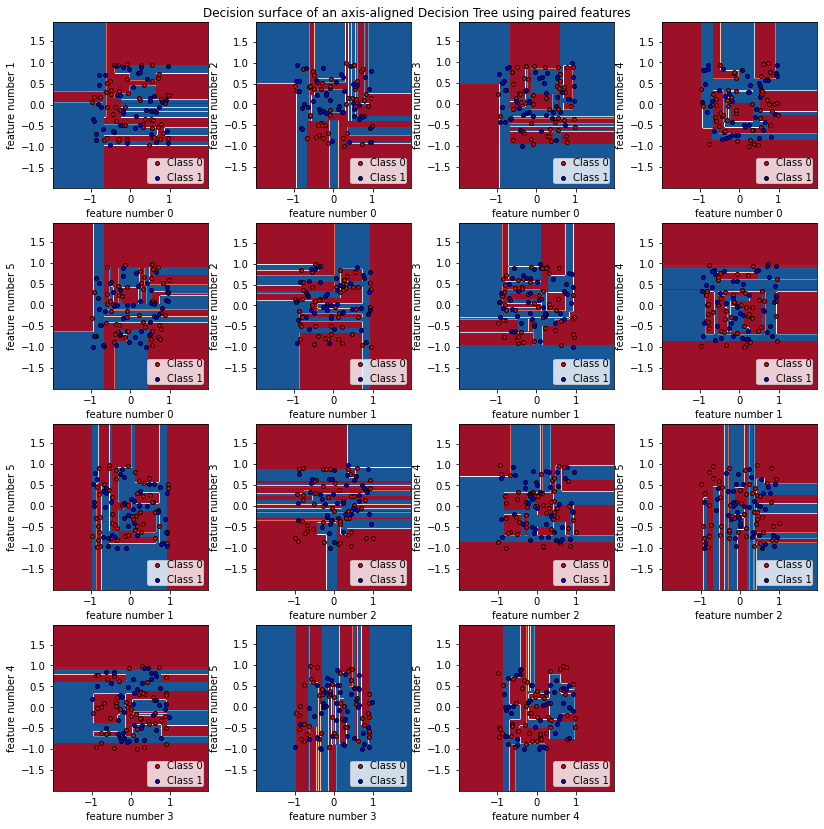

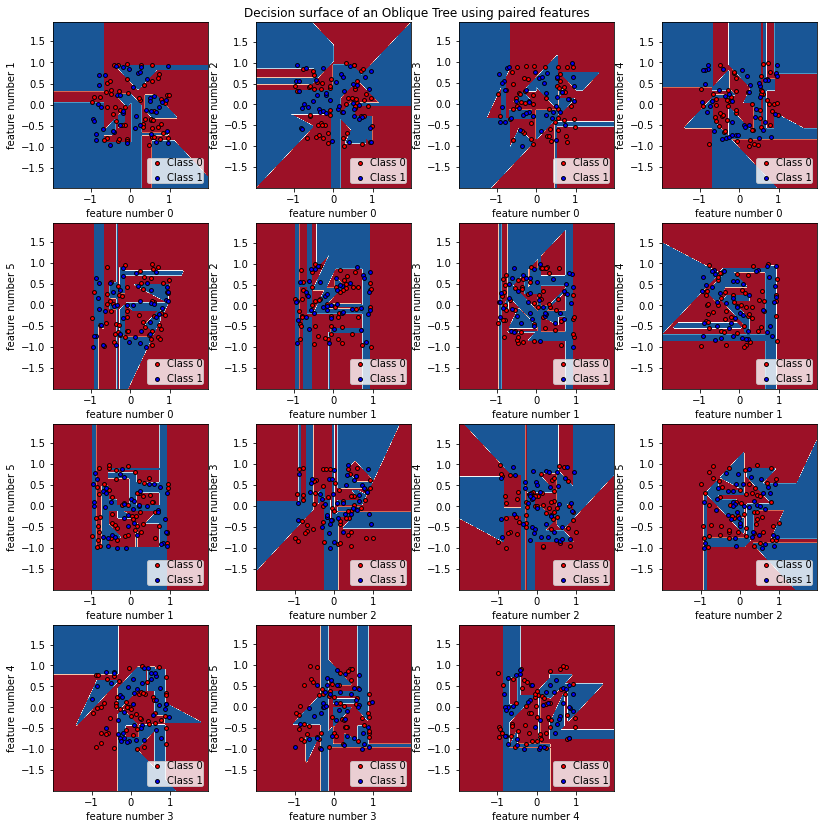

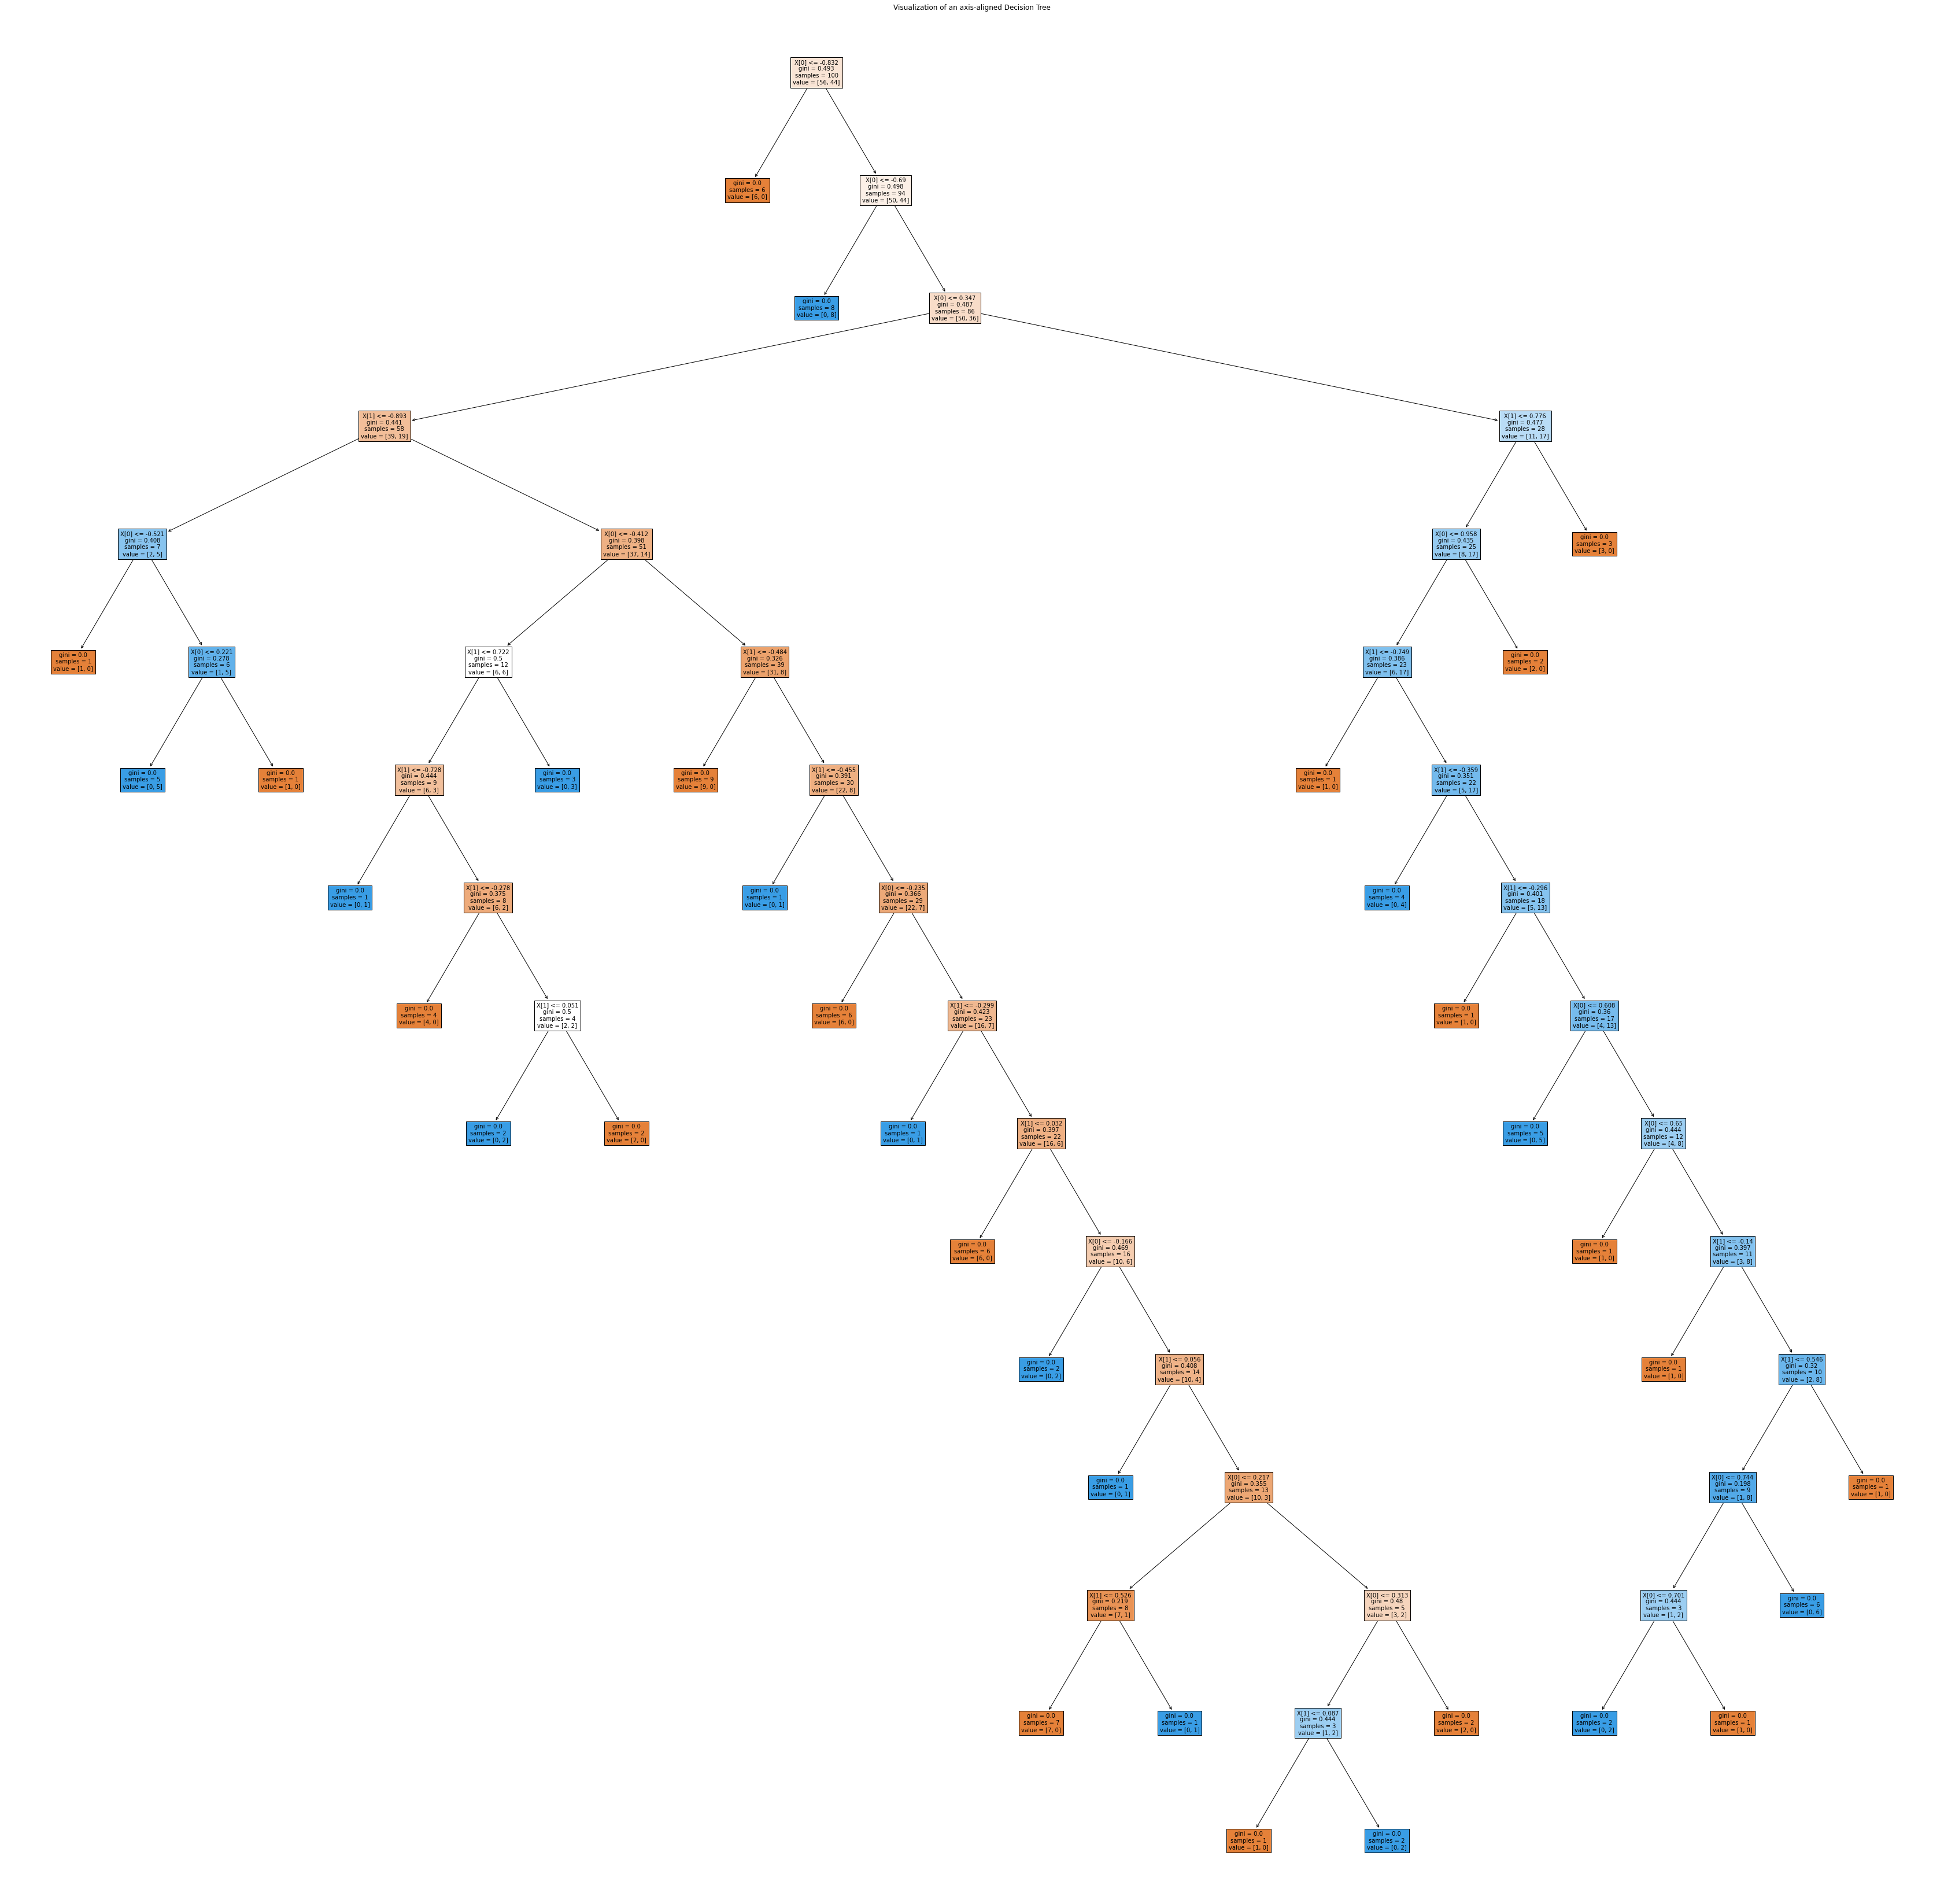

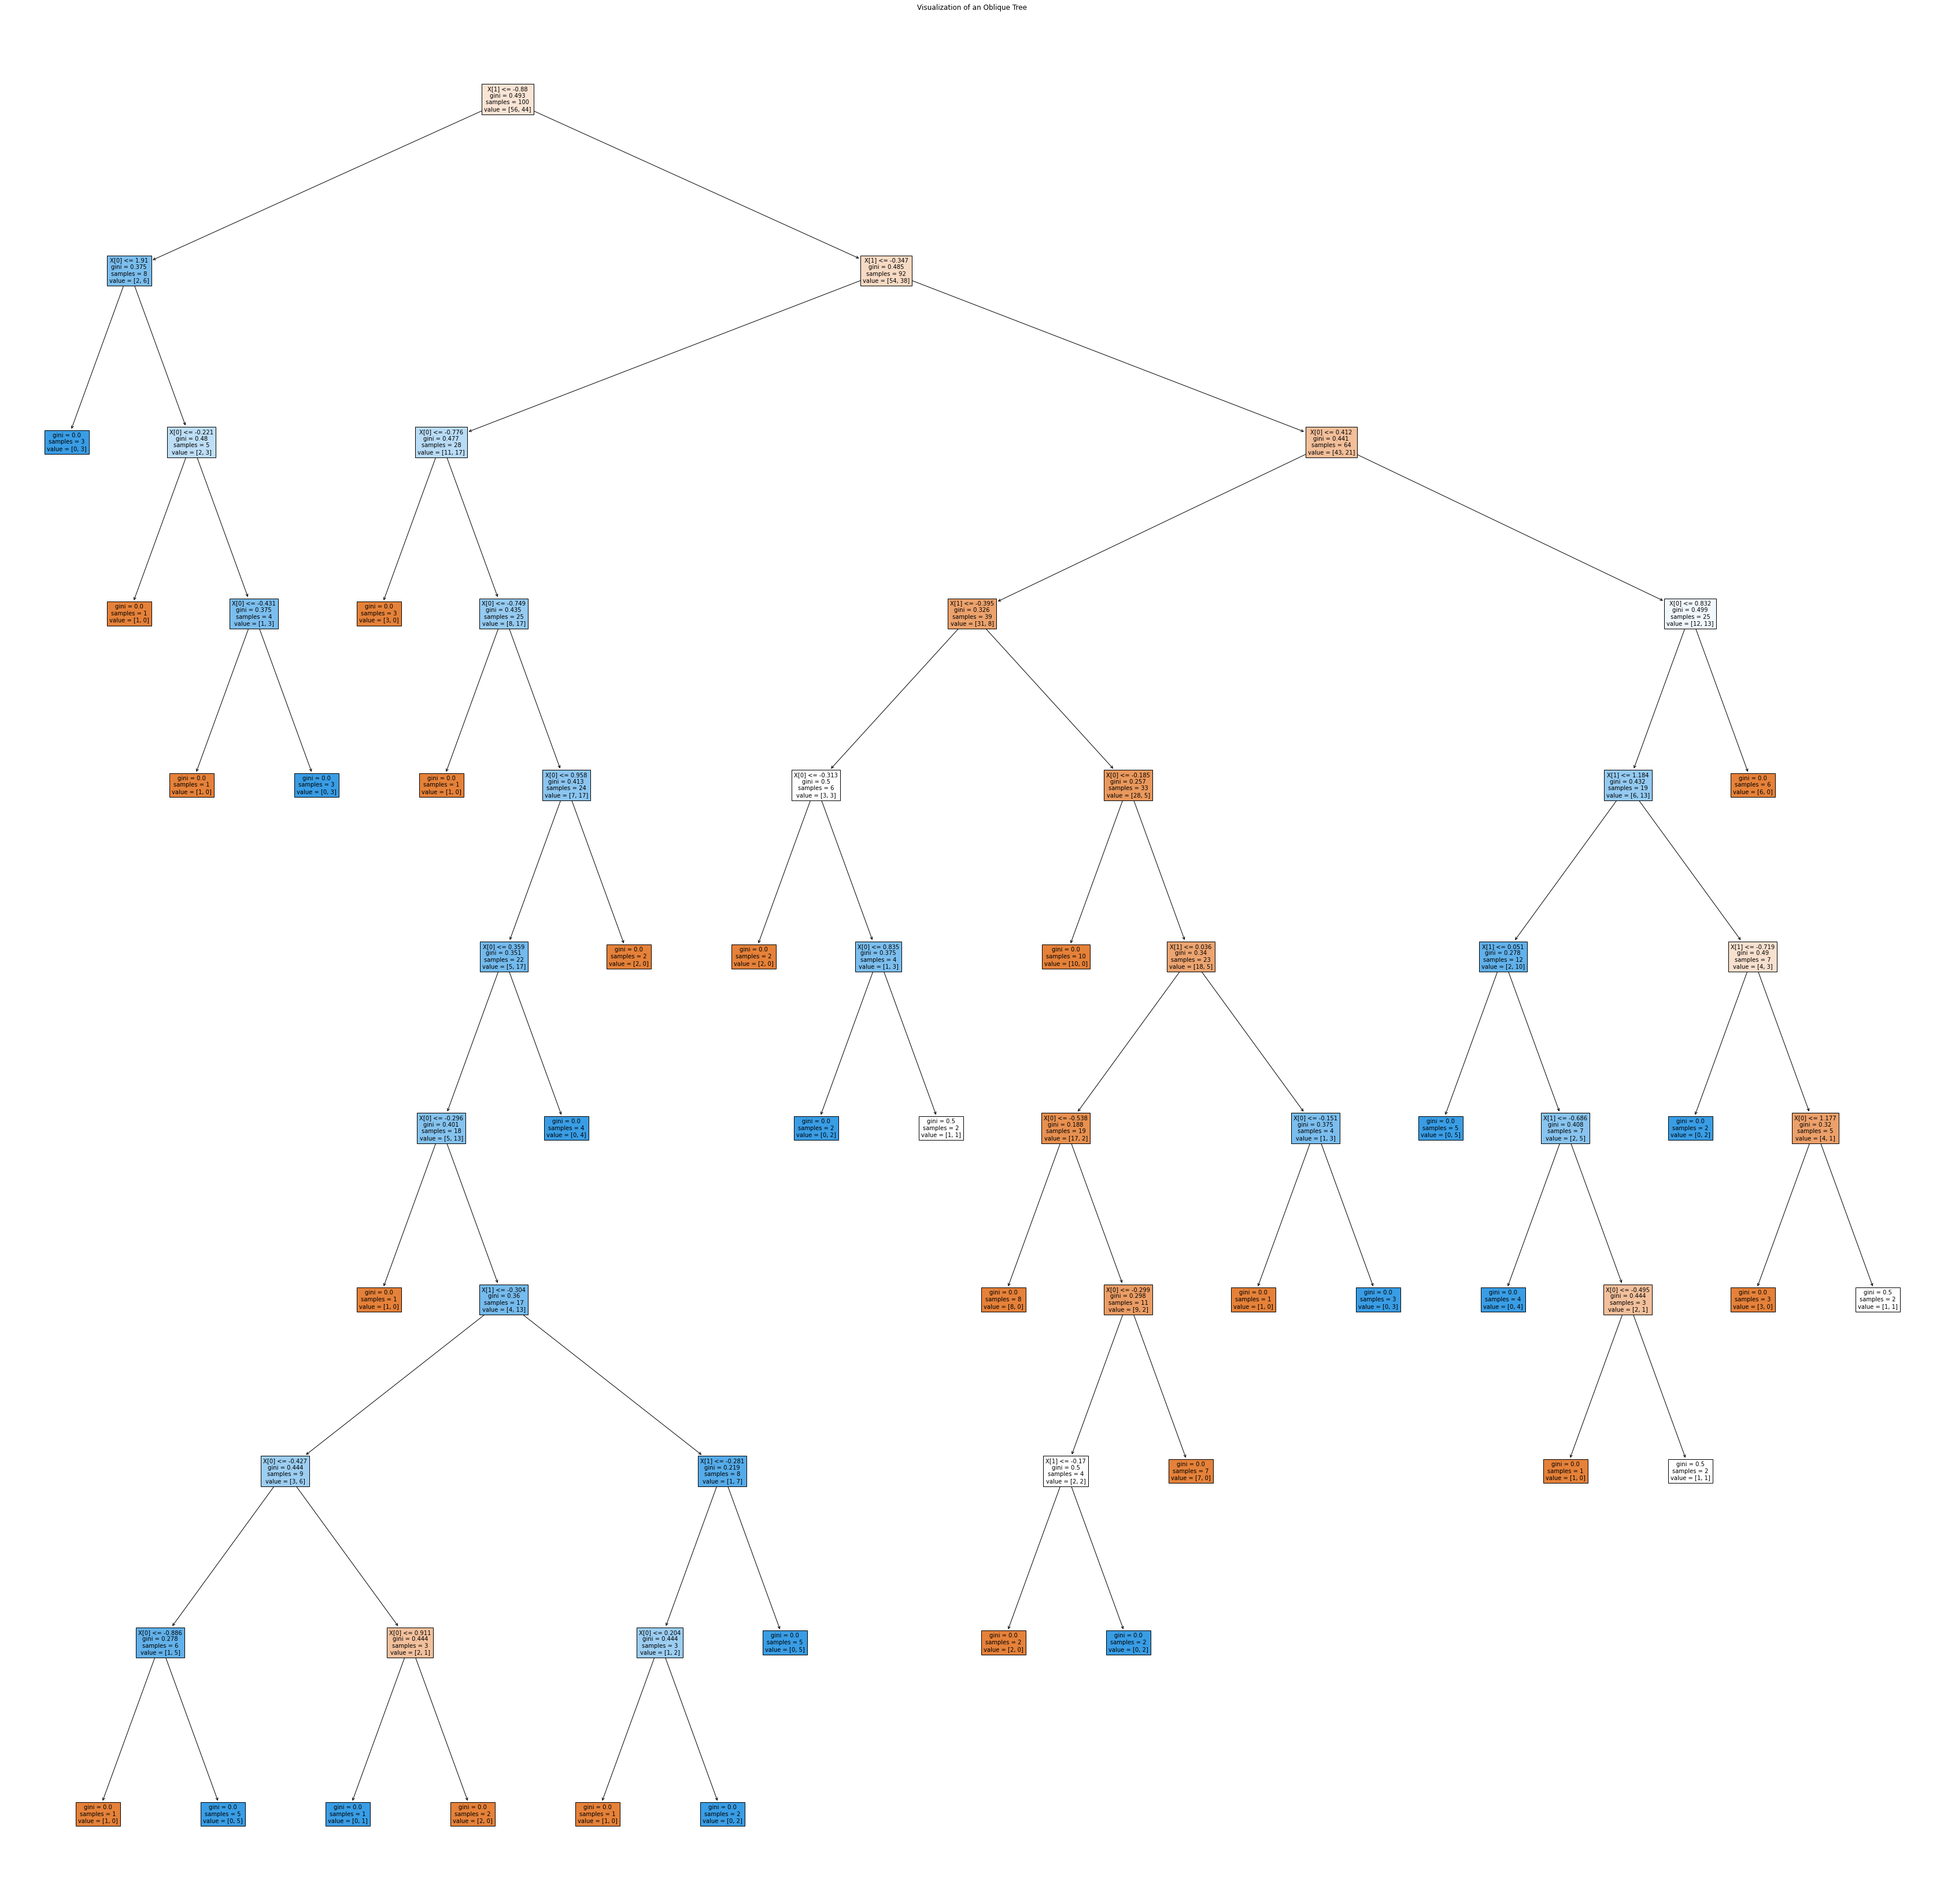

In [9]:
plot_decision_boundary(X, y, 123456)

#### Visualization analysis with `orthant` dataset

In [10]:
X, y = orthant(n=2000, p=6)
X.shape, y.shape

((2000, 6), (2000,))

In [11]:
cv_scores(X,y,random_seed=random_seed)

10-Fold CV score for axis-aligned decision tree is: 0.982 +/- 0.009273618495495713
10-Fold CV score for oblique decision tree is: 0.8724999999999999 +/- 0.031878676258590165


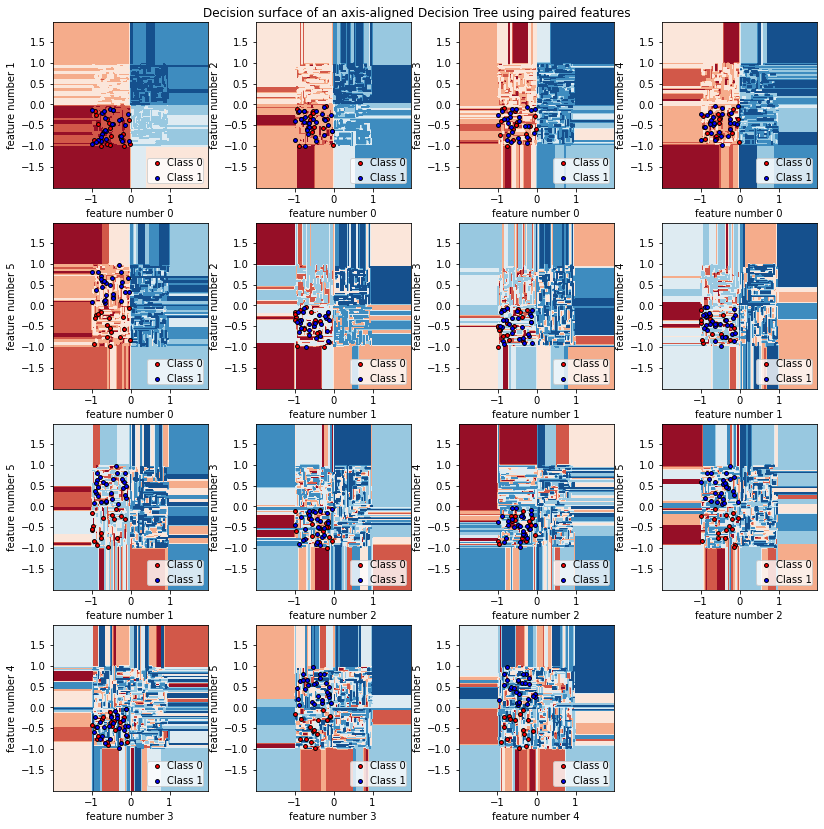

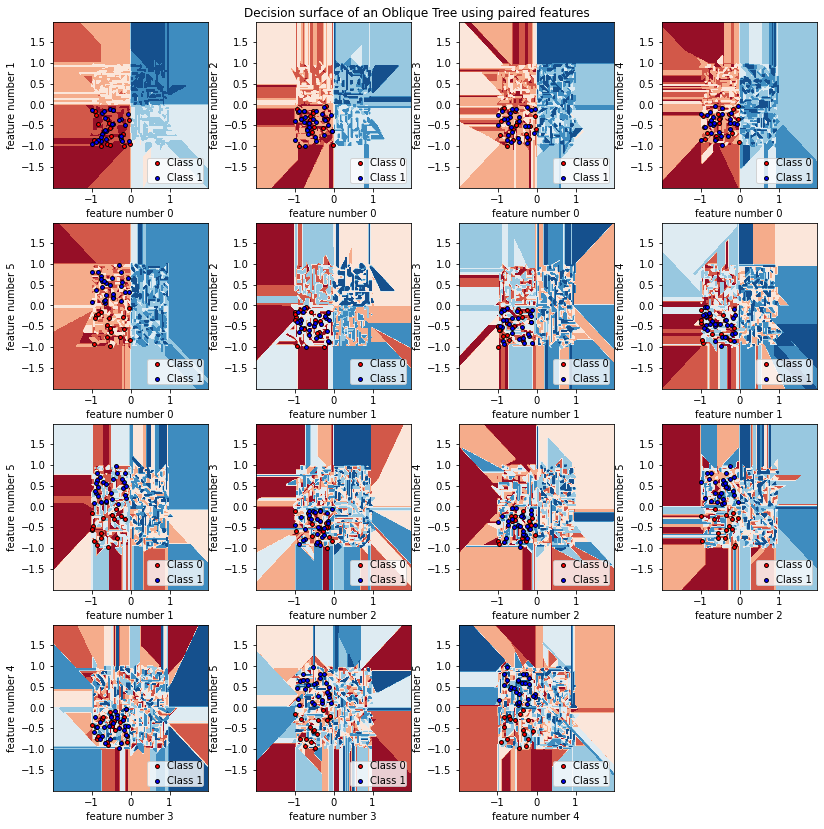

In [12]:
plot_decision_boundary(X, y, 123456, tree_vis=False)

#### Visualization analysis with `trunk` dataset

In [13]:
X, y = trunk(n=100, p=6)
X.shape, y.shape

((100, 6), (100,))

In [14]:
cv_scores(X,y,random_seed=random_seed)

10-Fold CV score for axis-aligned decision tree is: 0.78 +/- 0.16613247725836153
10-Fold CV score for oblique decision tree is: 0.85 +/- 0.10246950765959599


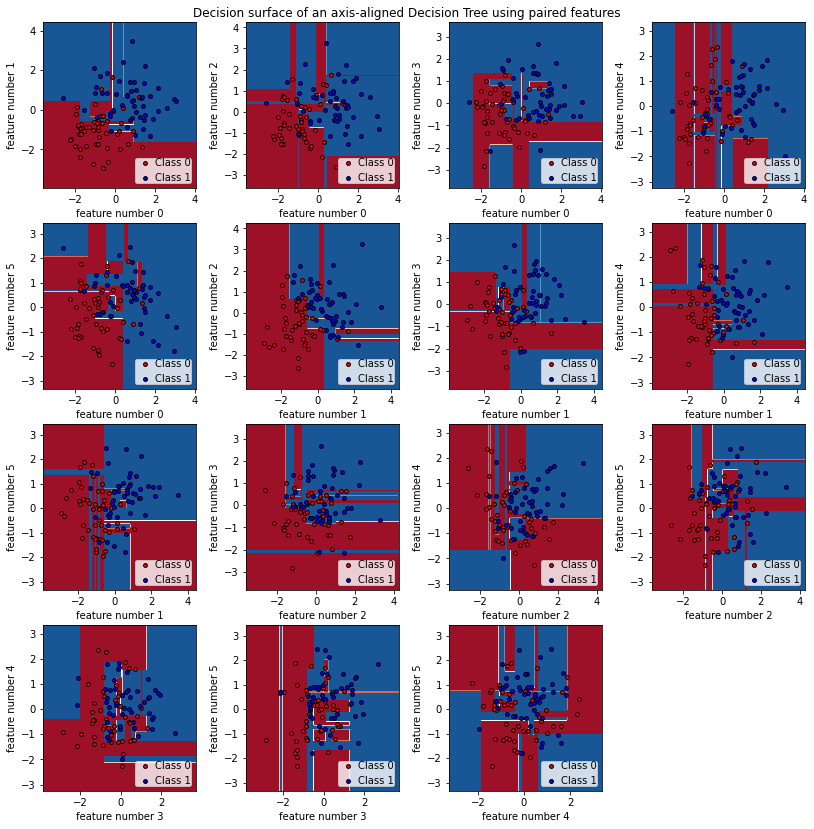

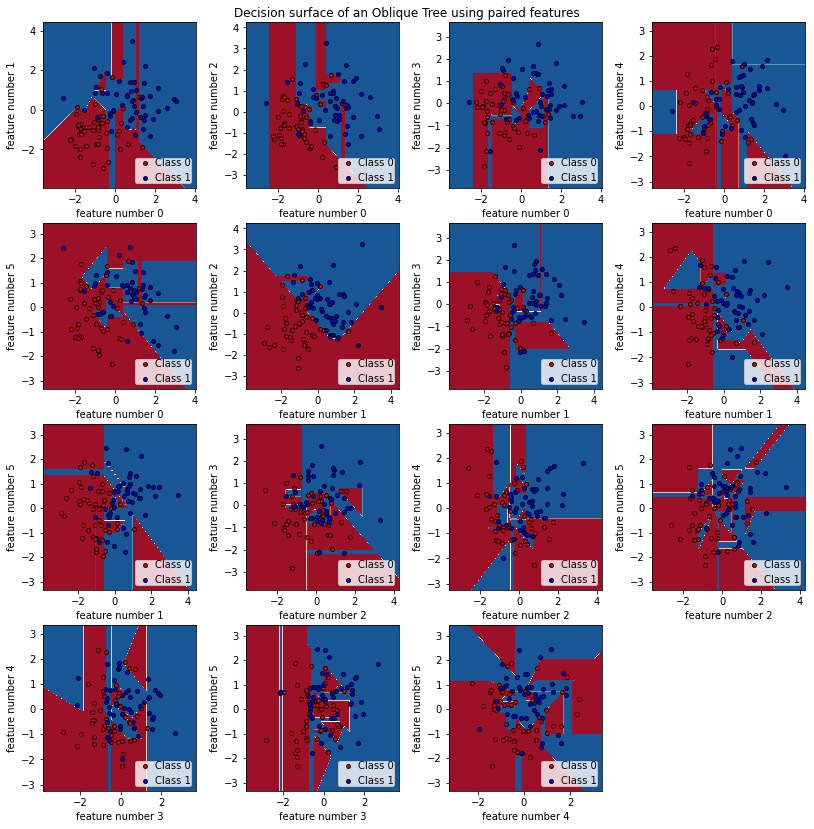

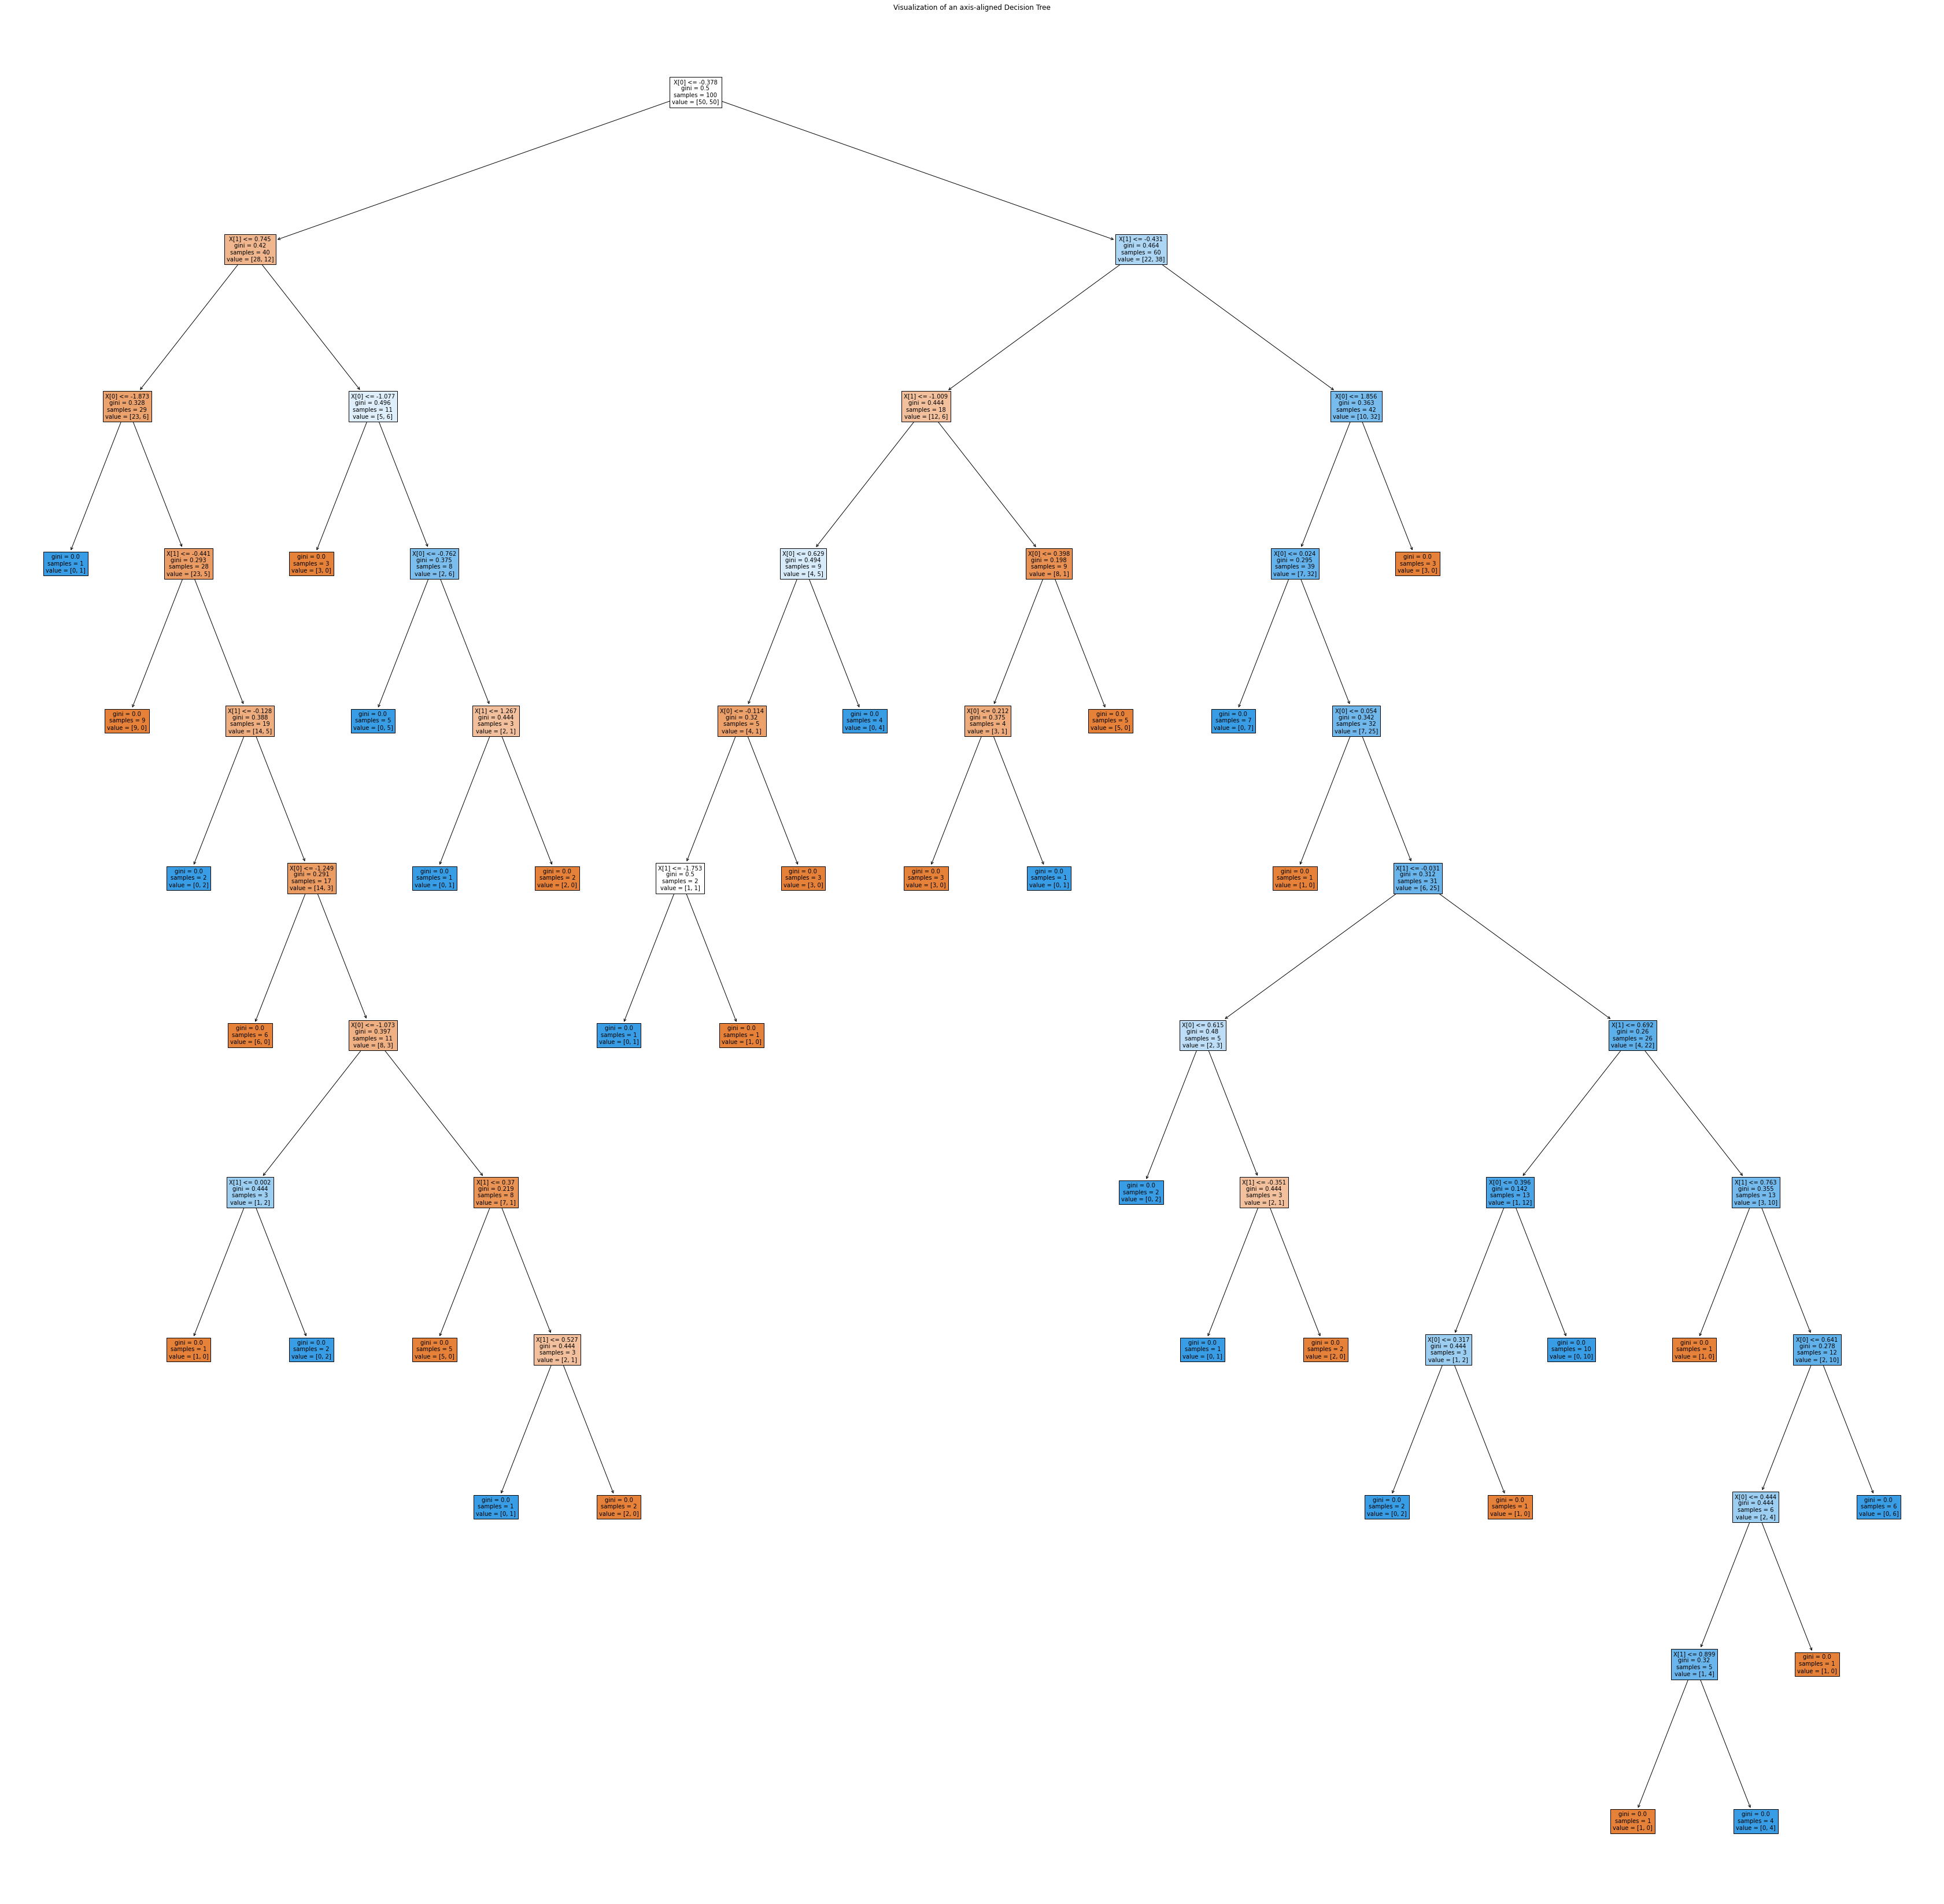

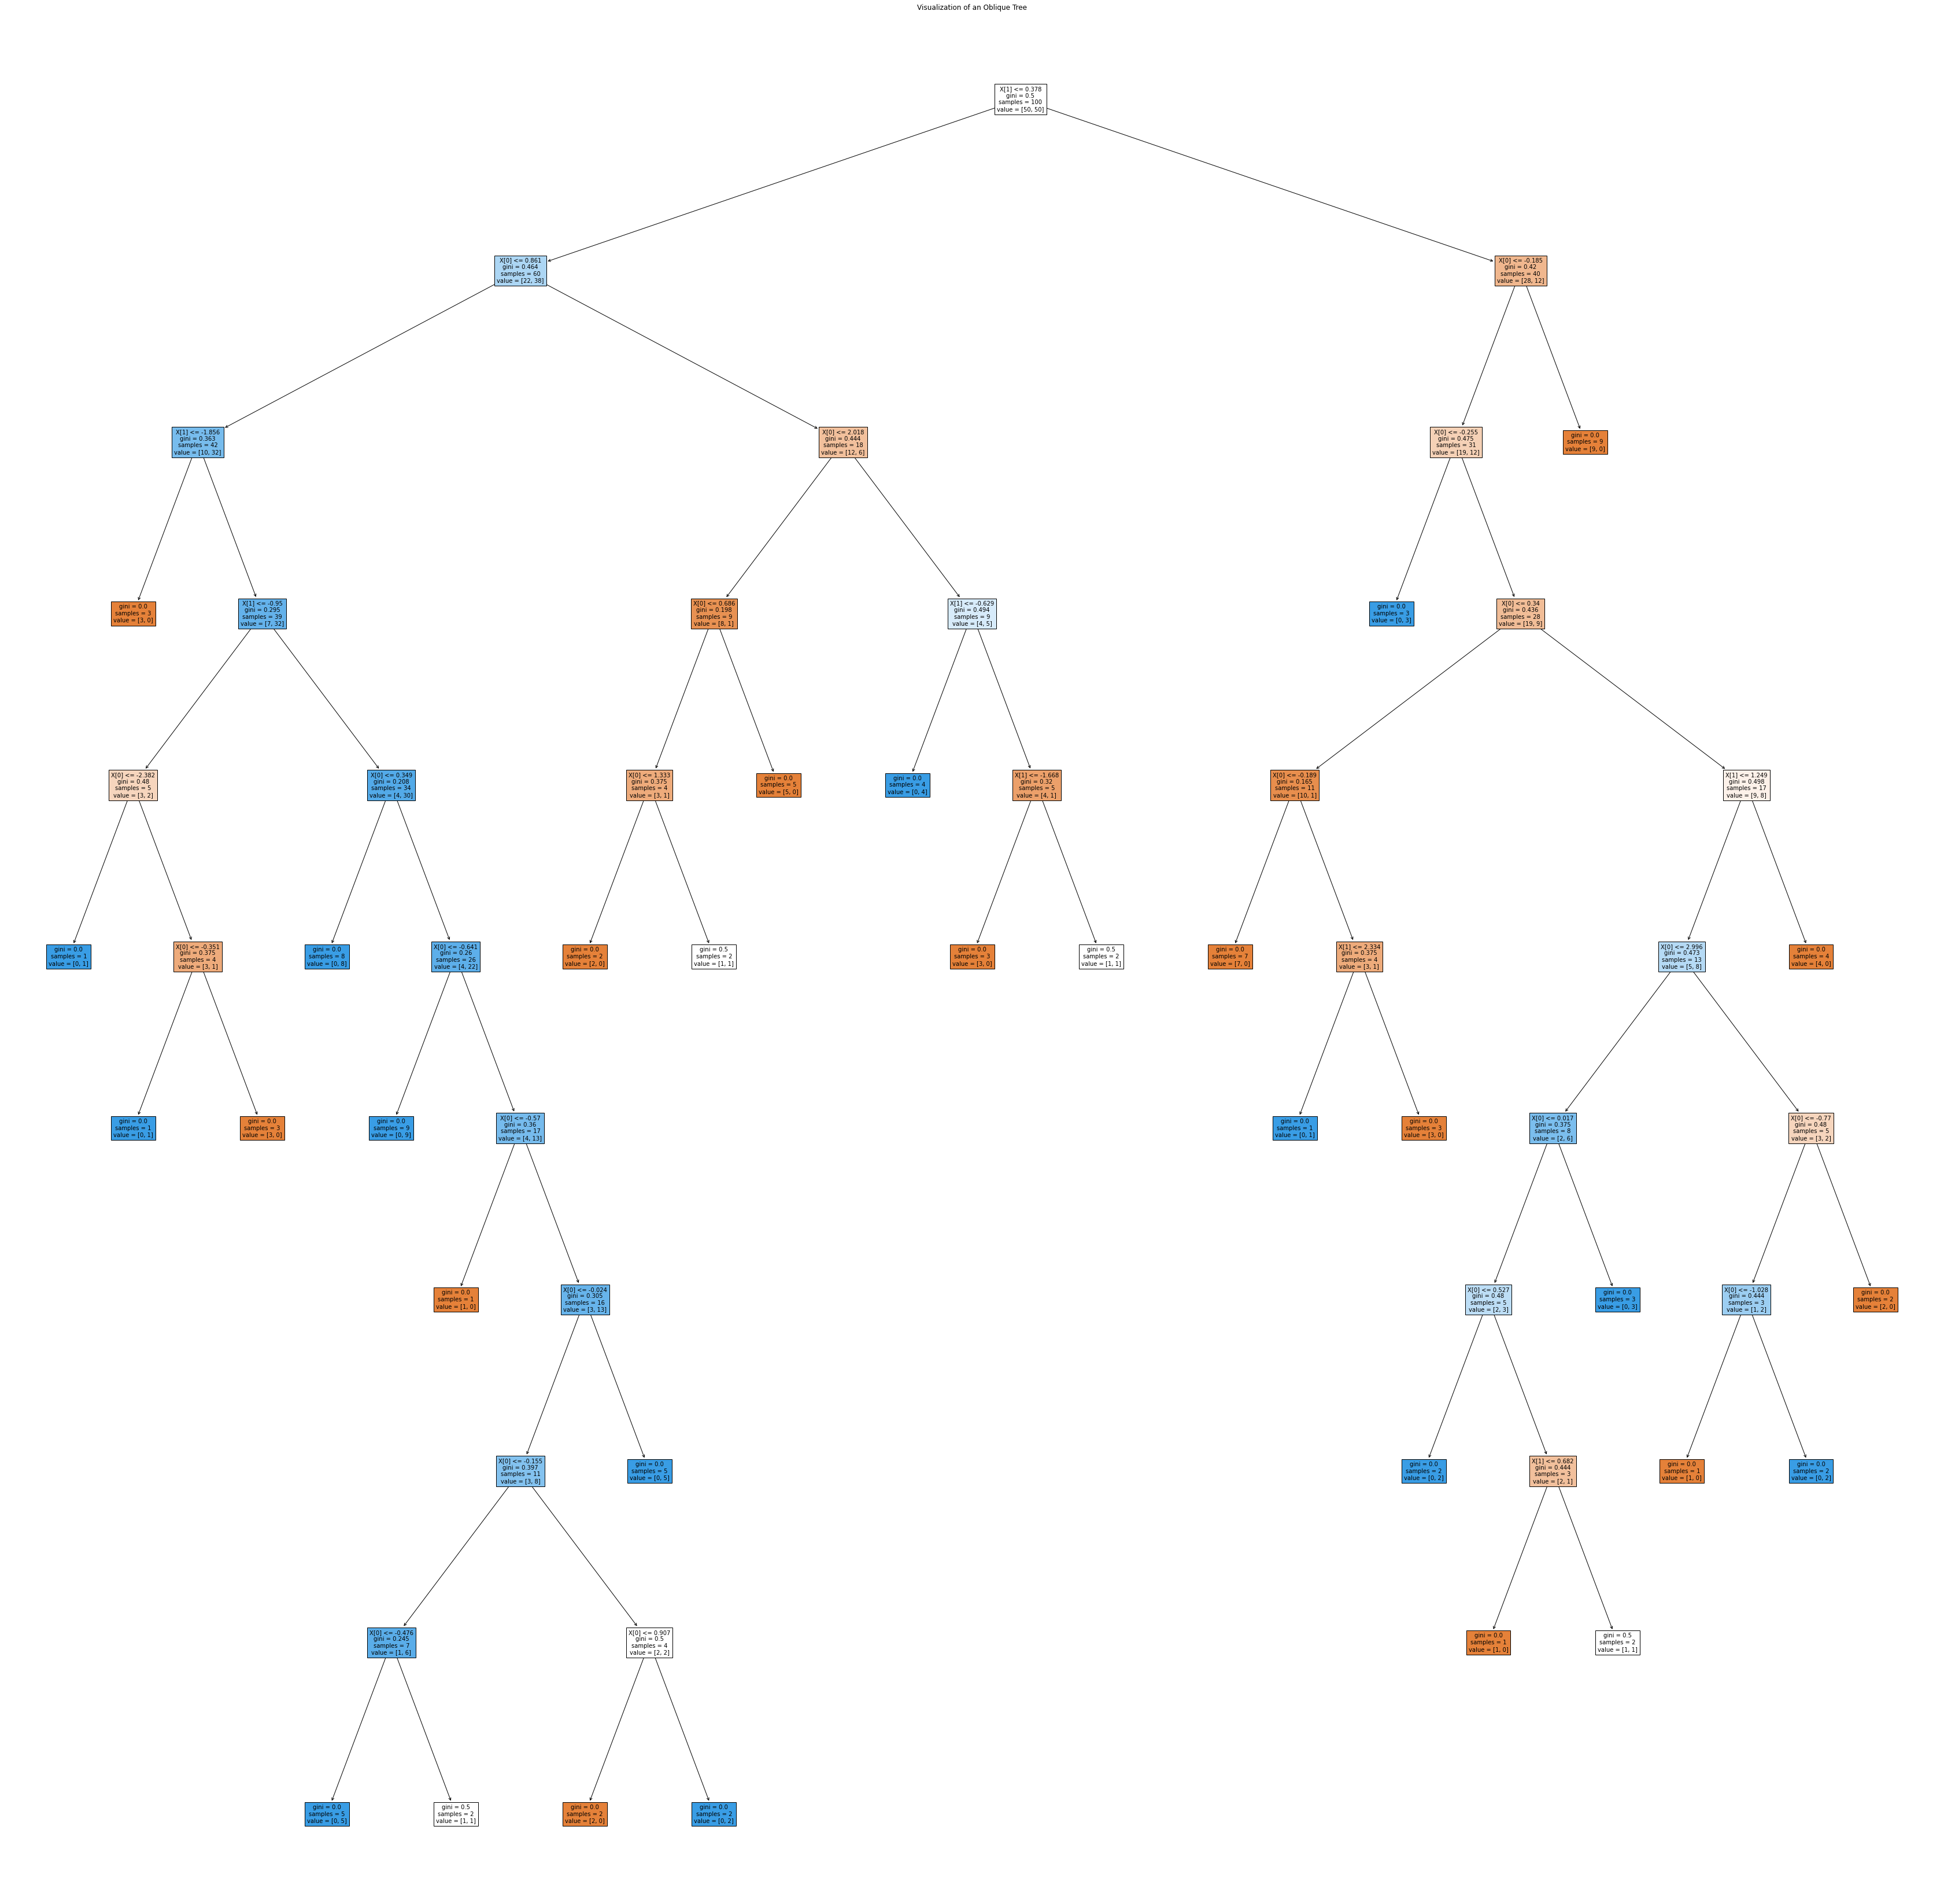

In [15]:
plot_decision_boundary(X, y, 123456)